In [163]:
from typing import Tuple, List
from collections import namedtuple

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

plt.style.use('ggplot')
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

In [164]:
FireLog = namedtuple('FireLog', ['time', 'origin', 'duration', 'casualties'])

In [165]:
class ForestFireField:
    def __init__(
        self,
        shape=(100, 100),
        wraparound=False,
        p_extinguish=0.15,
        p_spread_adj=0.45,
        p_spread_diag=0.15,
        p_spread_far=0.05,
        p_growth=0.05,
        p_fire=0.2,
    ) -> None:
        self.shape = shape

        self.wraparound = wraparound

        # a binary field representing existance of trees
        self.tree_field = np.ones(shape, dtype=bool)
        # a binary field representing existance of fire
        self.fire_field = np.zeros(shape, dtype=bool)

        # Parameters
        # short term
        self.p_extinguish = p_extinguish  # extinguish and burnt down to nothing
        self.p_spread_adj = p_spread_adj  # spread adjacently
        self.p_spread_diag = p_spread_diag  # spread diagonally
        self.p_spread_far = p_spread_far  # spread 2 cells along axis

        # long term
        self.p_growth = p_growth
        self.p_fire = p_fire  # probability of starting a fire randomly on anywhere of the map (lightning)

        # rng
        self.rng = np.random.default_rng()

    def reset_field(self):
        # todo? : not filling everywhere with trees
        self.tree_field = np.ones(self.shape, dtype=bool)
        self.fire_field = np.zeros(self.shape, dtype=bool)

    def step_growth(self) -> bool:
        """Move forward a time step on a large scale, simualting tree growth and fire starting event

        Returns:
            bool: If a fire should be started
        """
        rand_growth = self.rng.random(self.shape)
        self.tree_field = self.tree_field | (rand_growth < self.p_growth)

        rand_fire = self.rng.random()
        return rand_fire < self.p_fire

    def start_fire(self) -> Tuple[int, int]:
        """Start a fire randomly in a cell

        Returns:
            Tuple[int, int]: the cell in which fire started
        """
        row = self.rng.choice(self.shape[0])
        col = self.rng.choice(self.shape[1])
        self.fire_field[row, col] = True
        return (row, col)

    def step_burn(self):
        """Move forward a time step on a small scale, simulating spreading and burning of fire"""
        # extinguish fire
        rand_extinguish = self.rng.random(self.shape)
        self.tree_field = self.tree_field & ~(
            self.fire_field & (rand_extinguish < self.p_extinguish)
        )  # if HAS_FIRE and EXTINGUISH -> REMOVE_TREE
        self.fire_field = self.fire_field & self.tree_field  # if NO_TREE -> NO_FIRE

        # spread fire
        new_fire_field = np.zeros_like(self.fire_field, dtype=bool)

        directions = [
            [1, 0],
            [-1, 0],
            [0, 1],
            [0, -1],
            [1, 1],
            [-1, 1],
            [1, -1],
            [-1, -1],
            [2, 0],
            [-2, 0],
            [0, 2],
            [0, -2],
        ]

        for i, direction in enumerate(directions):
            if i < 4:
                p_spread = self.p_spread_adj
            elif i < 8:
                p_spread = self.p_spread_diag
            else:
                p_spread = self.p_spread_far

            rand_spread = self.rng.random(self.shape)

            has_adjacent_fire = np.roll(self.fire_field, direction, axis=(0, 1))
            if not self.wraparound:
                if direction[0] > 0:
                    has_adjacent_fire[: direction[0]] = False
                elif direction[0] < 0:
                    has_adjacent_fire[direction[0] :] = False
                if direction[0] > 0:
                    has_adjacent_fire[:, : direction[1]] = False
                elif direction[0] < 0:
                    has_adjacent_fire[:, direction[1] :] = False

            new_fire_field = new_fire_field | (
                (rand_spread < p_spread) & has_adjacent_fire
            )

        new_fire_field = new_fire_field & self.tree_field

        self.fire_field = self.fire_field | new_fire_field

    def run_fire(self):
        """Simulate a fire from start to finish

        Returns:
            t: fire burning duration
        """

        t = 0
        while self.fire_field.any():
            t += 1
            self.step_burn()
            if t > 1e3:  # it never ends!
                break

        return t

    def run_simulation(self, n_steps=100) -> Tuple[List, List[FireLog]]:
        """Runs the whole simulation for number of steps

        Args:
            n_steps (int, optional): number of large time steps. Defaults to 100.

        Returns:
            log_trees: record of tree numbers after each time step
            log_fires: record of each fire event, (timestep, origin, duration, number of burnt trees)
        """

        log_trees = []
        log_fires = []

        for t in tqdm(range(n_steps)):
            has_fire = self.step_growth()
            if has_fire:
                n_trees_before = self.tree_field.sum()

                fire_origin = self.start_fire()
                fire_duration = self.run_fire()

                n_trees_after = self.tree_field.sum()

                log_fires.append(
                    FireLog(
                        t, fire_origin, fire_duration, n_trees_before - n_trees_after
                    )
                )
            log_trees.append(self.tree_field.sum())

        return log_trees, log_fires

In [166]:
fire_sim = ForestFireField()
fire_sim.reset_field()
log_trees, log_fires = fire_sim.run_simulation(500)

print(log_trees[:10])
print(log_fires[:10])

  0%|          | 0/500 [00:00<?, ?it/s]

[10000, 10000, 10000, 10000, 10000, 40, 567, 1047, 1491, 1950]
[FireLog(time=5, origin=(99, 97), duration=452, casualties=9960), FireLog(time=9, origin=(67, 66), duration=1, casualties=0), FireLog(time=11, origin=(85, 91), duration=5, casualties=1), FireLog(time=12, origin=(46, 62), duration=1, casualties=0), FireLog(time=17, origin=(82, 84), duration=1, casualties=0), FireLog(time=23, origin=(25, 55), duration=70, casualties=129), FireLog(time=27, origin=(20, 58), duration=298, casualties=2169), FireLog(time=28, origin=(14, 46), duration=1, casualties=0), FireLog(time=29, origin=(87, 59), duration=1, casualties=0), FireLog(time=36, origin=(63, 92), duration=29, casualties=8)]


C:\Users\FKMS\AppData\Local\Temp\ipykernel_18292\2007803366.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


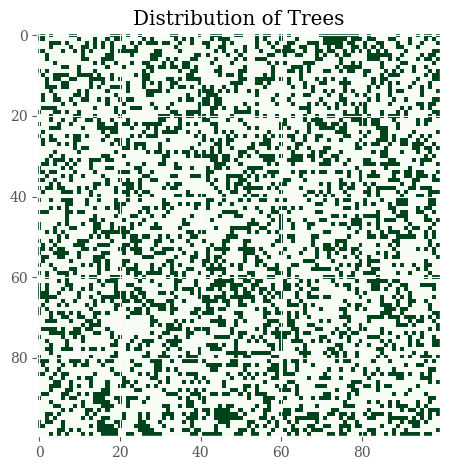

In [167]:
fig, ax = plt.subplots()
ax.imshow(fire_sim.tree_field, cmap="Greens")
ax.set(title="Distribution of Trees")
fig.tight_layout()
fig.show()

C:\Users\FKMS\AppData\Local\Temp\ipykernel_18292\1698723805.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


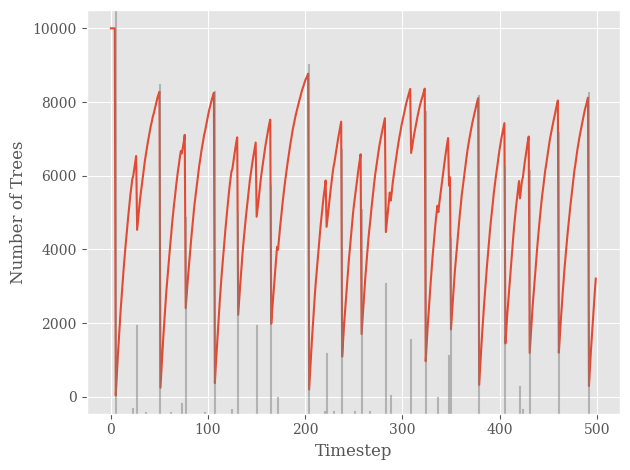

In [168]:
fig, ax = plt.subplots()
ax.plot(log_trees)
ax.set(xlabel="Timestep", ylabel="Number of Trees")
for fire in log_fires:
    if fire.casualties == 0:
        continue
    ax.axvline(fire.time, 0, fire.casualties / fire_sim.tree_field.size, c=[.5, .5, .5, .5])
fig.tight_layout()
fig.show()

## Scale of fire vs. Density of Tree

In [169]:
densities = []
scale_o_fire = []

for fire in log_fires:
    if fire.casualties == 0:
        continue
    densities.append((log_trees[fire.time] + fire.casualties) / fire_sim.tree_field.size )
    scale_o_fire.append(fire.casualties / fire_sim.tree_field.size )


C:\Users\FKMS\AppData\Local\Temp\ipykernel_18292\2452792955.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


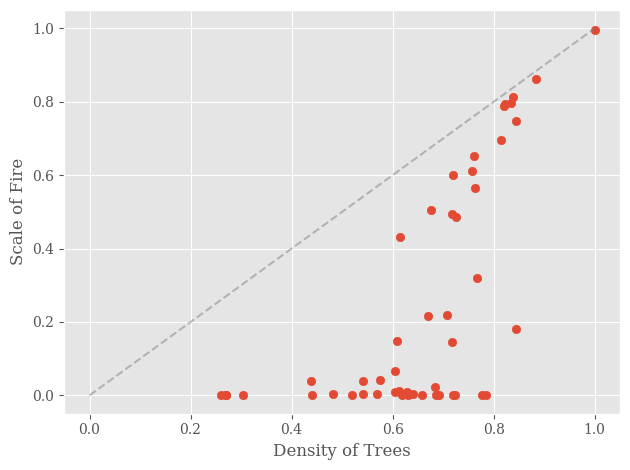

In [174]:
fig, ax = plt.subplots()
ax.plot([0,1],[0,1], c=[.5, .5, .5, .5], ls="--")
ax.scatter(densities, scale_o_fire)
ax.set(xlabel="Density of Trees", ylabel="Scale of Fire")
fig.tight_layout()
fig.show()